1. Setup and Data Preprocessing

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

# Load dataset
data = pd.read_csv('dataset/Almond.csv')  # Replace with your dataset path

# Display initial data
print("Initial Data:")
display(data.head())

# Handle missing values (if any)
print("\nMissing Values Before Imputation:")
print(data.isnull().sum())

# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
non_numeric_cols = data.select_dtypes(exclude=['number']).columns

# Fill missing values in numeric columns with the mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values in non-numeric columns with the mode (most frequent value)
data[non_numeric_cols] = data[non_numeric_cols].apply(lambda x: x.fillna(x.mode()[0]))

print("\nMissing Values After Imputation:")
print(data.isnull().sum())

# Feature Engineering: Add derived features (e.g., aspect ratio, eccentricity)
# Assuming 'Length' and 'Width' are columns in your dataset
if 'Length' in data.columns and 'Width' in data.columns:
    data['Aspect_Ratio'] = data['Length'] / data['Width']
else:
    print("\nColumns 'Length' and 'Width' not found for aspect ratio calculation.")

# Encode the labels (if they are strings)
label_encoder = LabelEncoder()
data['Type'] = label_encoder.fit_transform(data['Type'])

# Split features and target
X = data.drop('Type', axis=1).values
y = data['Type'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Check the number of classes
n_classes = len(np.unique(y))
print(f"\nNumber of classes: {n_classes}")

Initial Data:


,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA



Missing Values Before Imputation:
Unnamed: 0                     0
Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

Missing Values After Imputation:
Unnamed: 0                  0
Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

Columns 'Length' and '

2. Defining Neural Network Model

In [2]:
# Create a neural network model
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

3. Defining Hybrid Optimizer

In [3]:
def hybrid_optimizer(model, X_train, y_train, X_test, y_test, epochs=50):
    # Optimizers
    adam_opt = Adam(learning_rate=0.001)
    rprop_opt = RMSprop(learning_rate=0.001)

    # Compile model with Adam first
    model.compile(
        optimizer=adam_opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history_adam = model.fit(
        X_train, y_train, validation_data=(X_test, y_test),
        epochs=epochs, batch_size=10, verbose=0
    )
    adam_weights = model.get_weights()
    adam_loss = history_adam.history['loss'][-1]

    # Compile model with RProp
    model.compile(
        optimizer=rprop_opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history_rprop = model.fit(
        X_train, y_train, validation_data=(X_test, y_test),
        epochs=epochs, batch_size=10, verbose=0
    )
    rprop_weights = model.get_weights()
    rprop_loss = history_rprop.history['loss'][-1]

    # Average the weights
    hybrid_weights = [
        (0.5 * a + 0.5 * r) for a, r in zip(adam_weights, rprop_weights)
    ]
    model.set_weights(hybrid_weights)

    return model, history_adam, history_rprop

4. Training Loop and Correlation Calculation

In [4]:
def calculate_weight_correlation(adam_weights, rprop_weights):
    # Flatten the weights and compute correlation for each layer
    correlations = [
        np.corrcoef(a.flatten(), r.flatten())[0, 1]
        for a, r in zip(adam_weights, rprop_weights)
    ]
    return correlations  # Return correlations per layer

# Multiple independent runs
def run_experiments(n_runs=10, epochs=50):
    adam_accuracies = []
    rprop_accuracies = []
    hybrid_accuracies = []
    correlations = []

    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        # Adam model
        adam_model = create_model(optimizer='adam')
        adam_model.fit(
            X_train, y_train, epochs=epochs, batch_size=10, verbose=0
        )
        y_pred_adam = adam_model.predict(X_test)
        adam_acc = accuracy_score(y_test, np.argmax(y_pred_adam, axis=1))
        adam_accuracies.append(adam_acc)

        # RProp model
        rprop_model = create_model(optimizer='rmsprop')
        rprop_model.fit(
            X_train, y_train, epochs=epochs, batch_size=10, verbose=0
        )
        y_pred_rprop = rprop_model.predict(X_test)
        rprop_acc = accuracy_score(y_test, np.argmax(y_pred_rprop, axis=1))
        rprop_accuracies.append(rprop_acc)

        # Hybrid model
        hybrid_model = create_model()
        hybrid_model, history_adam, history_rprop = hybrid_optimizer(
            hybrid_model, X_train, y_train, X_test, y_test, epochs=epochs
        )
        y_pred_hybrid = hybrid_model.predict(X_test)
        hybrid_acc = accuracy_score(y_test, np.argmax(y_pred_hybrid, axis=1))
        hybrid_accuracies.append(hybrid_acc)

        # Correlation between weight updates
        weight_correlation = calculate_weight_correlation(
            adam_model.get_weights(), rprop_model.get_weights()
        )
        correlations.append(weight_correlation)

    # Output results
    print(f"\nAdam mean accuracy: {np.mean(adam_accuracies):.4f}, std: {np.std(adam_accuracies):.4f}")
    print(f"RProp mean accuracy: {np.mean(rprop_accuracies):.4f}, std: {np.std(rprop_accuracies):.4f}")
    print(f"Hybrid mean accuracy: {np.mean(hybrid_accuracies):.4f}, std: {np.std(hybrid_accuracies):.4f}")

    # Average correlation per layer
    avg_correlations = np.mean(correlations, axis=0)
    for idx, corr in enumerate(avg_correlations):
        print(f"Average weight correlation for layer {idx + 1}: {corr:.4f}")

    return adam_accuracies, rprop_accuracies, hybrid_accuracies, correlations

5. Running the Experiments and Visualisation of Results

Run 1/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Run 2/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 3/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 4/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Run 5/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Run 6/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Run 7/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 8/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 9/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Run 10/10


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


c:\Users\edwin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Adam mean accuracy: 0.9877, std: 0.0054
RProp mean accuracy: 0.9859, std: 0.0037
Hybrid mean accuracy: 0.9888, std: 0.0034
Average weight correlation for layer 1: 0.0005
Average weight correlation for layer 2: -0.0054
Average weight correlation for layer 3: 0.0099
Average weight correlation for layer 4: 0.0890
Average weight correlation for layer 5: 0.0214
Average weight correlation for layer 6: 0.9498


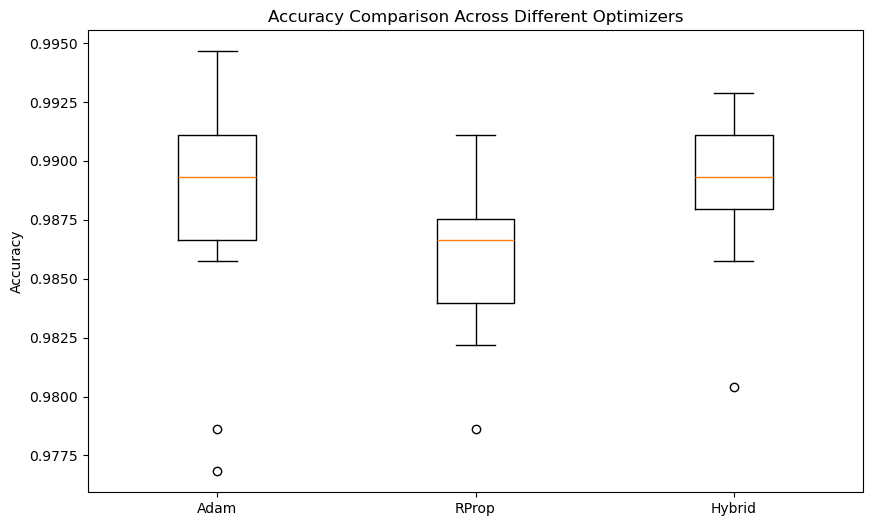

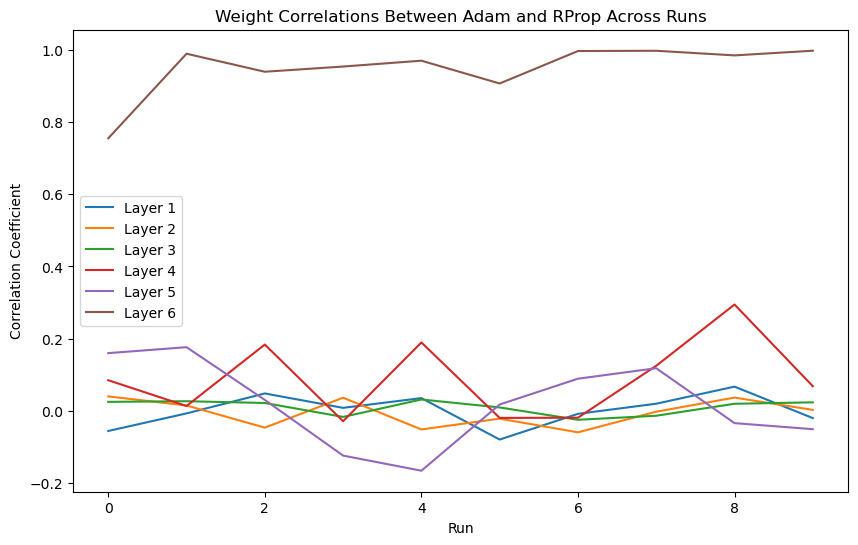

In [5]:
adam_acc, rprop_acc, hybrid_acc, correlations = run_experiments(n_runs=10, epochs=50)

# Plotting accuracies
methods = ['Adam', 'RProp', 'Hybrid']
accuracies = [adam_acc, rprop_acc, hybrid_acc]

plt.figure(figsize=(10, 6))
plt.boxplot(accuracies, labels=methods)
plt.title('Accuracy Comparison Across Different Optimizers')
plt.ylabel('Accuracy')
plt.show()

# Convert correlations to numpy array for easier manipulation
correlations = np.array(correlations)

# Plot correlations per layer
layers = [f'Layer {i+1}' for i in range(correlations.shape[1])]

plt.figure(figsize=(10, 6))
for i, layer in enumerate(layers):
    plt.plot(correlations[:, i], label=layer)

plt.title('Weight Correlations Between Adam and RProp Across Runs')
plt.xlabel('Run')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()